# Modeling Usage Example

In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import tensorflow as tf

from vtt.data.caption_preprocessing import load_tokenizer
from vtt.data.data_loader import load_split_datasets
from vtt.models.decoder import build_decoder_model
from vtt.models.train import train_model
from vtt.visualization.history_plot import plot_training_history
from vtt.models.predict import display_images_with_greedy_captions, display_images_with_beam_captions

## Paths

In [82]:
dataset_name = "flickr8k"
features_path = f"../data/processed/{dataset_name}_features.npz"
captions_path = f"../data/processed/{dataset_name}_padded_caption_sequences.npz"
tokenizer_path = f"../data/processed/{dataset_name}_tokenizer.json"
captions_file = f"../data/raw/{dataset_name}_captions.csv"

## Load Tokenizer and Features

In [83]:
tokenizer = load_tokenizer(tokenizer_path)
features = np.load(features_path)

[INFO] Tokenizer loaded from JSON file: ../data/processed/flickr8k_tokenizer.json


## Load Datasets

In [84]:
train_ds, val_ds, test_ds = load_split_datasets(
    features_path=features_path,
    captions_path=captions_path,
    batch_size=64,
    val_split=0.15,
    test_split=0.10,
    shuffle=True,
    buffer_size=1000,
    seed=42,
    cache=True,
    return_numpy=False
)


--- Dataset Split Sizes (number of individual samples) ---
Total samples loaded: 38008
Train samples: 28507
Validation samples: 5701
Test samples: 3800
----------------------------------------------------------



## Build Model

In [15]:
# Get max caption length from dataset
for (image_tensor, input_caption, _), _ in train_ds.take(1):
    max_caption_len = input_caption.shape[1]
# Get vocab size
vocab_size = tokenizer.num_words

model = build_decoder_model(vocab_size=vocab_size, max_caption_len=max_caption_len)
model.summary()

2025-07-17 21:25:50.742595: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-07-17 21:25:50.743524: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "ImageCaptionDecoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_dense (Dense) │ (None, 256)       │    524,544 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_input       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_image        │ (None, 1, 256)    │          0 │ image_dense[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_embedding   │ (None, 18, 256)   │  2,560,000 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_image_caption │ (None, 19, 256)   │          0 │ expand_image[0][… │
│ (Concatenate)       │                   │            │ caption_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 19, 512)   │  1,574,912 │ merge_image_capt… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 19, 10000) │  5,130,000 │ lstm[0][0]        │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trim_image_output   │ (None, 18, 10000) │          0 │ output_dense[0][… │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,789,456 (37.34 MB)

 Trainable params: 9,789,456 (37.34 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [ ]:
# Train model
history = train_model(
    dataset=train_ds,
    model=model,
    epochs=25,
    val_dataset=val_ds,
    checkpoint_path="../models/flickr8k_decoder_weights.weights.h5",
    early_stop_patience=5,
)

Epoch 1/25


2025-07-16 12:44:53.588828: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 2.3329
Epoch 1: val_loss improved from inf to 2.15353, saving model to ../models/flickr8k_decoder_weights.weights.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 167s 375ms/step - loss: 2.3327 - val_loss: 2.1535
Epoch 2/25
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 2.1180
Epoch 2: val_loss improved from 2.15353 to 2.03975, saving model to ../models/flickr8k_decoder_weights.weights.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 166s 374ms/step - loss: 2.1179 - val_loss: 2.0397
Epoch 3/25
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - loss: 1.9947
Epoch 3: val_loss improved from 2.03975 to 1.96670, saving model to ../models/flickr8k_decoder_weights.weights.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 167s 376ms/step - loss: 1.9946 - val_loss: 1.9667
Epoch 4/25
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - loss: 1.9003
Epoch 4: val_loss improved from 1.96670 to 1.91423, saving model to ../models/flickr8k_decoder_weights.weights.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 167s 375ms/step -

## Save Trained Model

In [38]:
save_path = "../models/flickr8k_decoder_model.keras"
model.save(save_path)

## Plot Training History

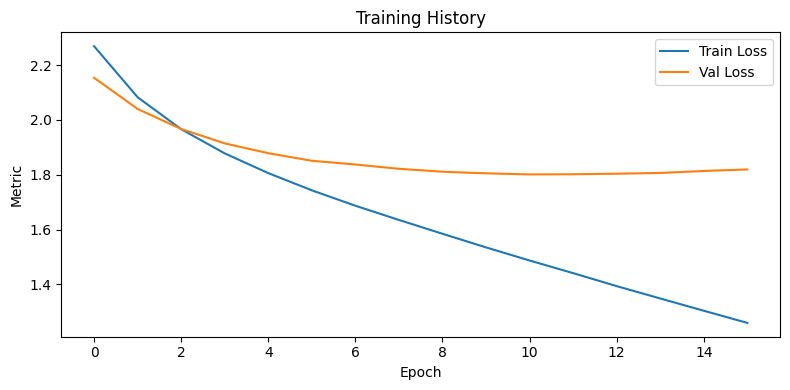

In [39]:
# New plot
plot_training_history(history, metrics=["loss"])

## Load the saved Model Weights

In [85]:
model = build_decoder_model(vocab_size=vocab_size,
                            max_caption_len=max_caption_len)

checkpoint_path = "../models/flickr8k_decoder_weights.weights.h5"
model.load_weights(checkpoint_path)
print("Loaded pretrained weights")


Loaded pretrained weights


/opt/miniconda3/envs/genai_project/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Predict Sample Captions from Test Set

In [93]:
import random

# Step 1: Unbatch and collect all image IDs from test_ds
all_image_ids = [img_id.numpy().decode('utf-8') for (_, _, img_id), _ in test_ds.unbatch()]

# Step 2: Sample 5 random IDs
sample_image_ids = random.sample(all_image_ids, 5)


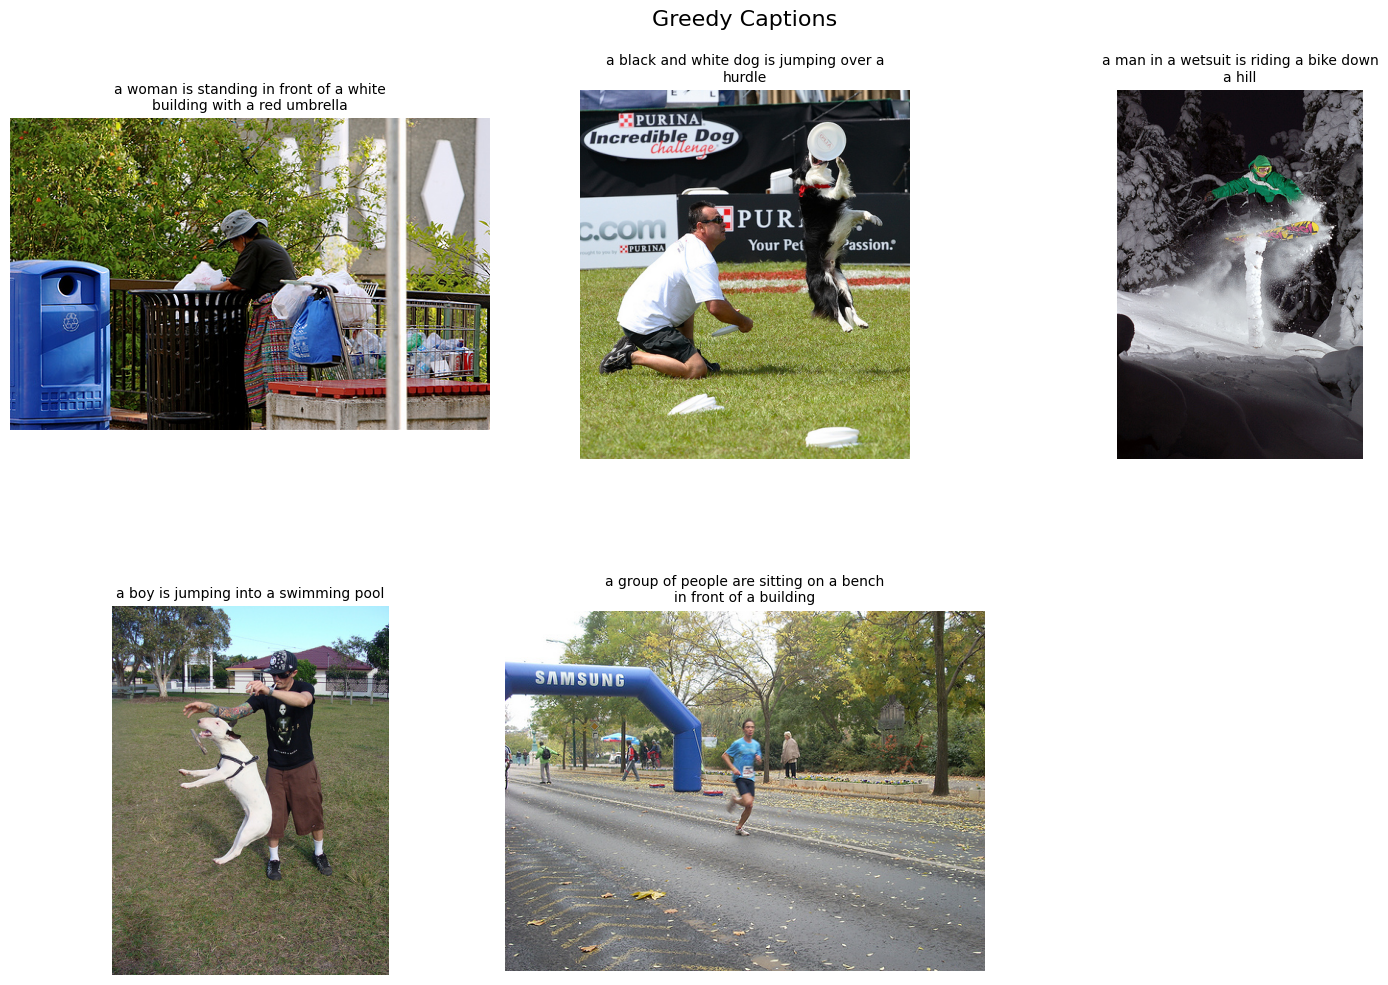

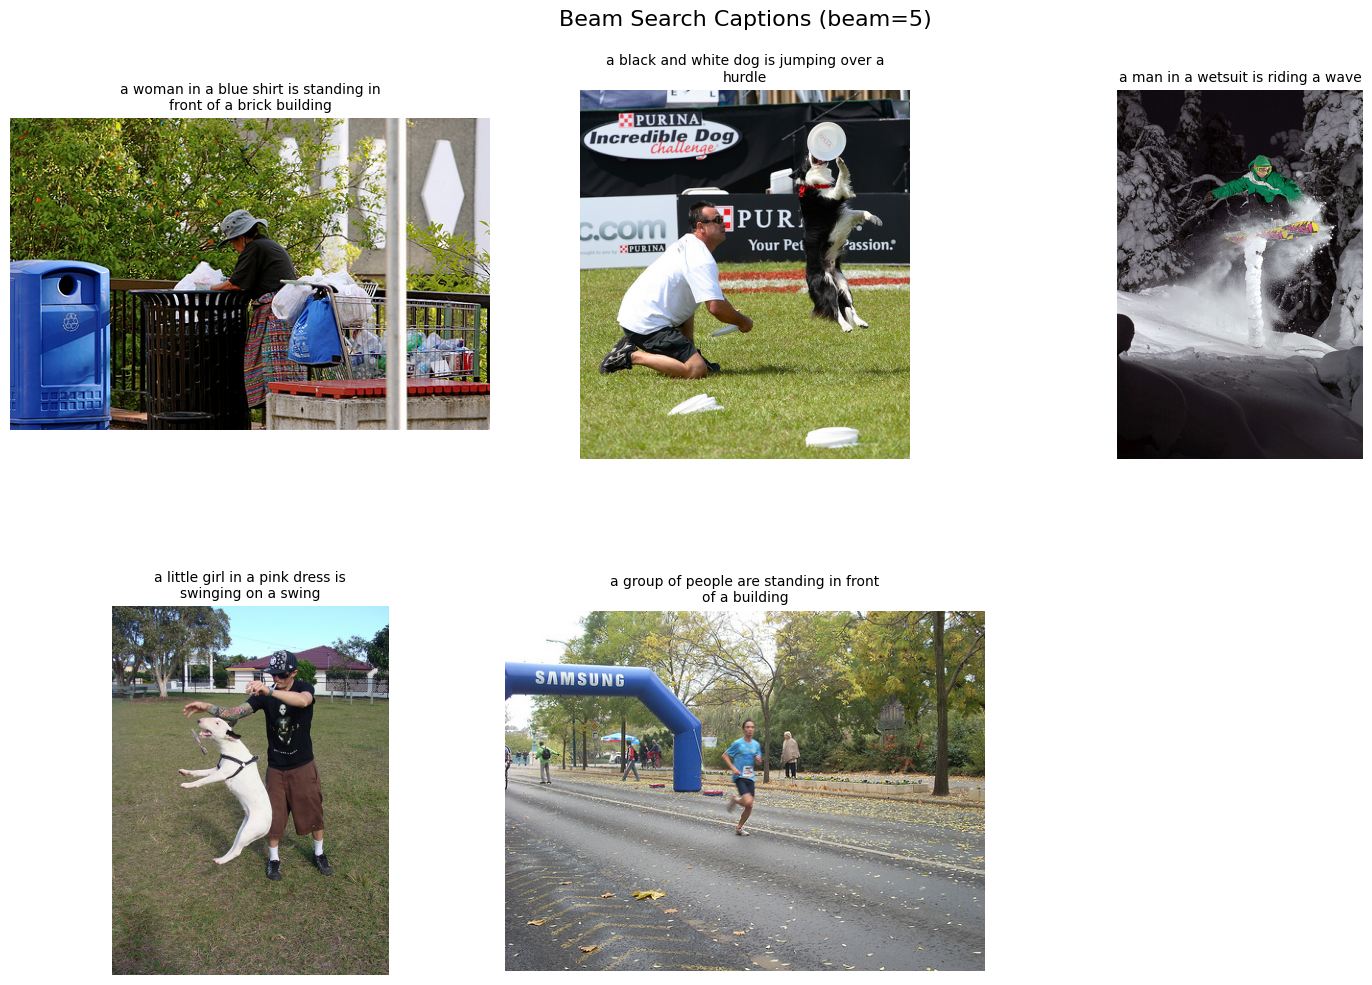

In [ ]:
image_folder = "../data/flickr8k_images_dataset/Images"

# Step 3: Call display_images_with_captions
display_images_with_greedy_captions(
    image_ids=sample_image_ids,
    model=model,
    tokenizer=tokenizer,
    features=features,
    image_folder=image_folder
)

display_images_with_beam_captions(
    image_ids=sample_image_ids,
    model=model,
    tokenizer=tokenizer,
    features=features,
    image_folder=image_folder,
    beam_width=5,
    max_len=max_caption_len,
    cols=3,
)
